The goal is to train a neural network to predict the parameters of an equation

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import copy

## 1. Does it work for the simple affine model: $y=ax+b$?

In [28]:
class Net(nn.Module):
    def __init__(self, L):
        super().__init__()
        L = torch.tensor(L, dtype=torch.float)
        
        kernel_size, stride, dilation, padding = 5, 1, 1, 0
        self.conv1 = nn.Conv1d(1, 2, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding)
        L = torch.floor((L+2*padding-dilation*(kernel_size-1)-1)/stride+1)
        
        
        kernel_size, stride, dilation, padding = 5, 1, 1, 0
        self.pool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding)
        L = torch.floor((L+2*padding-dilation*(kernel_size-1)-1)/stride+1)
        
        print(L)
        
        self.fc1 = nn.Linear(L.int().item() * 2, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [29]:
a = torch.randn(300, 2, 1)
x = torch.arange(-10, 10, 0.1).unsqueeze(0)
y = a[:, 0] + a[:, 1] * x
a = a.squeeze(-1)
y_training = y[:150]
a_training = a[:150]
y_validation = y[150:200]
a_validation = a[150:200]
y_test = y[200:]
a_test = a[200:]

In [30]:
a[0:5]

tensor([[ 0.4113,  0.5444],
        [ 0.7071,  0.8218],
        [ 0.8734,  0.0374],
        [-0.7091,  0.4547],
        [-0.4296, -1.1299]])

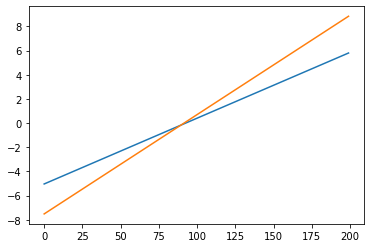

In [31]:
plt.plot(y[0:2].T)

In [32]:
x.shape

torch.Size([1, 200])

In [33]:
a_training.shape, net(y_training).shape, y.shape

(torch.Size([150, 2]), torch.Size([150, 1]), torch.Size([300, 200]))

tensor(192.)


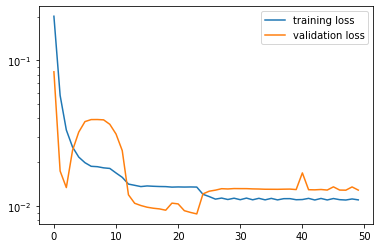

In [34]:
net = Net(x.shape[-1])

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

running_loss = 0
training_loss_list = []
validation_loss_list = []
best_coeff = 0
best_loss = torch.inf

for i in range(5000):
    optimizer.zero_grad()   # zero the gradient buffers
    a_pred = net(y_training)
    loss = criterion(a_training, a_pred)
    loss.backward()
    optimizer.step()  
    
    # print statistics
    running_loss += loss.item()
    if i % 100 == 99:
#        print(list(net.parameters()))
        print(f'[{i + 1:5d}] loss: {running_loss / 100:.8f}', end='\r')
        training_loss_list.append(running_loss / 100)
        running_loss = 0.0
        
        a_pred = net(y_validation)
        validation_loss = criterion(a_validation, a_pred)
        validation_loss_list.append(validation_loss.cpu().detach().numpy())
        
plt.plot(training_loss_list, label='training loss')
plt.plot(validation_loss_list, label='validation loss')
plt.legend()
plt.yscale('log')

In [35]:
criterion(net(y_test), a_test)

tensor(0.0067, grad_fn=<MseLossBackward0>)

In [36]:
a_test[0:2]

tensor([[-1.6884, -0.6018],
        [-1.1052, -0.8337]])

In [37]:
net(y_test[0:2])

tensor([[-1.6062, -0.5872],
        [-1.0974, -0.8490]], grad_fn=<AddmmBackward0>)

## 2. How does it go for non linear data: $y=\cos(ax)$

In [56]:
a = torch.randn(500, 1)
x = torch.arange(-10, 10, 0.1).unsqueeze(0)
y = torch.cos(a * x)
y_training = y[:350]
a_training = a[:350]
y_validation = y[350:400]
a_validation = a[350:400]
y_test = y[400:]
a_test = a[400:]

In [57]:
a[0:5]

tensor([[-1.2316],
        [-0.6468],
        [-0.5366],
        [ 0.4783],
        [ 0.1488]])

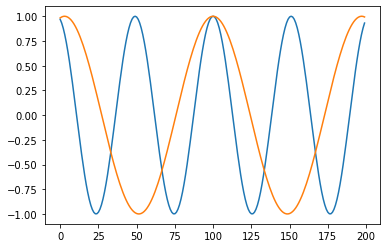

In [58]:
plt.plot(y[0:2].T)

In [55]:
class CNN(nn.Module):
    def __init__(self, L):
        super().__init__()
        L = torch.tensor(L, dtype=torch.float)
        
        kernel_size, stride, dilation, padding = 5, 1, 1, 0
        self.conv1 = nn.Conv1d(1, 2, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding)
        L = torch.floor((L+2*padding-dilation*(kernel_size-1)-1)/stride+1)
        
        print(f'Planned length after conv1: {L}') 
        
        kernel_size, stride, dilation, padding = 5, 1, 2, 0
        self.pool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding)
        L = torch.floor((L+2*padding-dilation*(kernel_size-1)-1)/stride+1)
        
        print(f'Planned length after 1st pool: {L}') 
        
        
        kernel_size, stride, dilation, padding = 5, 1, 1, 0
        self.conv2 = nn.Conv1d(2, 4, kernel_size=kernel_size, stride=stride, dilation=dilation, padding=padding)
        L = torch.floor((L+2*padding-dilation*(kernel_size-1)-1)/stride+1)
        
        print(f'Planned length after conv2: {L}') 

        kernel_size, stride, dilation, padding = 5, 1, 2, 0
        L = torch.floor((L+2*padding-dilation*(kernel_size-1)-1)/stride+1)
        print(f'Planned length after 2nd pool: {L}') 
        
        self.fc1 = nn.Linear(L.int().item() * 4, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.abs(self.fc3(x))
        return x

Planned length after conv1: 196.0
Planned length after 1st pool: 188.0
Planned length after conv2: 184.0
Planned length after 2nd pool: 176.0


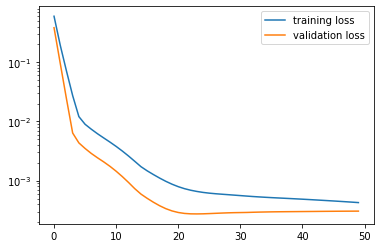

In [57]:
net = CNN(x.shape[-1])

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

running_loss = 0
training_loss_list = []
validation_loss_list = []
best_coeff = 0
best_loss = torch.inf

for i in range(5000):
    optimizer.zero_grad()   # zero the gradient buffers
    a_pred = net(y_training)
    loss = criterion(torch.abs(a_training), a_pred)
    loss.backward()
    optimizer.step()  
    
    # print statistics
    running_loss += loss.item()
    if i % 100 == 99:
#        print(list(net.parameters()))
        print(f'[{i + 1:5d}] loss: {running_loss / 100:.8f}', end='\r')
        training_loss_list.append(running_loss / 100)
        running_loss = 0.0
        
        a_pred = net(y_validation)
        validation_loss = criterion(torch.abs(a_validation), a_pred)
        validation_loss_list.append(validation_loss.cpu().detach().numpy())
        
plt.plot(training_loss_list, label='training loss')
plt.plot(validation_loss_list, label='validation loss')
plt.legend()
plt.yscale('log')

In [59]:
class MLP(nn.Module):
    def __init__(self, L, n_params):
        super().__init__()
        self.fc1 = nn.Linear(L, 50)
        self.fc2 = nn.Linear(50, n_params)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.abs(self.fc2(x))
        return x

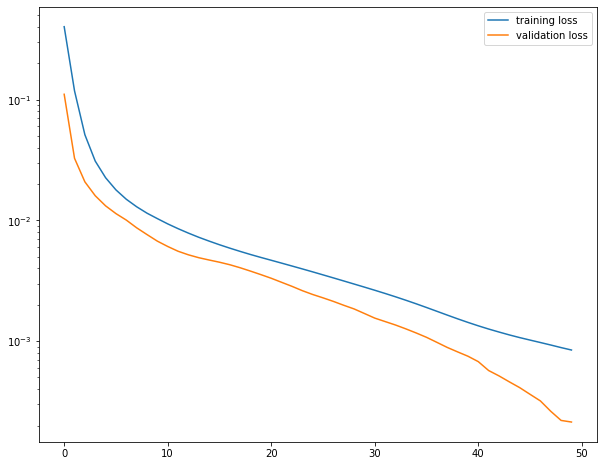

In [73]:
net = MLP(x.shape[-1], n_params=a.shape[1])

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

running_loss = 0
training_loss_list = []
validation_loss_list = []
best_coeff = 0
best_loss = torch.inf

figure, ax = plt.subplots(figsize=(10, 8))

for i in range(5000):
    optimizer.zero_grad()   # zero the gradient buffers
    a_pred = net(y_training)
    loss = criterion(torch.abs(a_training), a_pred)
    loss.backward()
    optimizer.step()  
    
    # print statistics
    running_loss += loss.item()
    if i % 100 == 99:
#        print(list(net.parameters()))
        
        a_pred = net(y_validation)
        validation_loss = criterion(torch.abs(a_validation), a_pred)
        validation_loss_list.append(validation_loss.cpu().detach().numpy())
        
        print(f'[{i + 1:5d}] training loss: {running_loss / 100:.8f}, validation loss: {validation_loss:.8f}', end='\r')
        training_loss_list.append(running_loss / 100)
        running_loss = 0.0

        
plt.plot(training_loss_list, label='training loss')
plt.plot(validation_loss_list, label='validation loss')
plt.legend()
plt.yscale('log')

In [74]:
criterion(net(y_validation), torch.abs(a_validation))

tensor(0.0002, grad_fn=<MseLossBackward0>)

In [75]:
criterion(net(y_test), torch.abs(a_test))

tensor(0.0027, grad_fn=<MseLossBackward0>)

In [76]:
a_test[:2], net(y_test[0:2])

(tensor([[ 1.2162],
         [-0.2779]]),
 tensor([[1.2036],
         [0.2792]], grad_fn=<AbsBackward0>))

In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [77]:
count_parameters(net)

10101

## 3. How does it go for more parameters: $y=a + bx + cx^2 + d x^3$

In [79]:
class MLP(nn.Module):
    def __init__(self, L, n_params):
        super().__init__()
        self.fc1 = nn.Linear(L, 50)
        self.fc2 = nn.Linear(50, n_params)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [80]:
a = torch.randn(300, 4, 1)
x = torch.arange(-10, 10, 0.1).unsqueeze(0)
y = a[:, 0] + a[:, 1] * x + a[:, 2] * x**2 + a[:, 3] * x**3
y_training = y[:150]
a_training = a[:150]
y_validation = y[150:200]
a_validation = a[150:200]
y_test = y[200:]
a_test = a[200:]

In [81]:
a[0:2]

tensor([[[-1.3959],
         [-1.5442],
         [ 0.3257],
         [-0.2414]],

        [[-0.2169],
         [ 0.8655],
         [ 0.0501],
         [-1.5141]]])

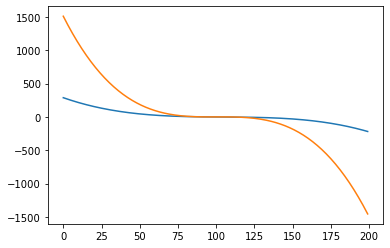

In [82]:
plt.plot(y[0:2].T)

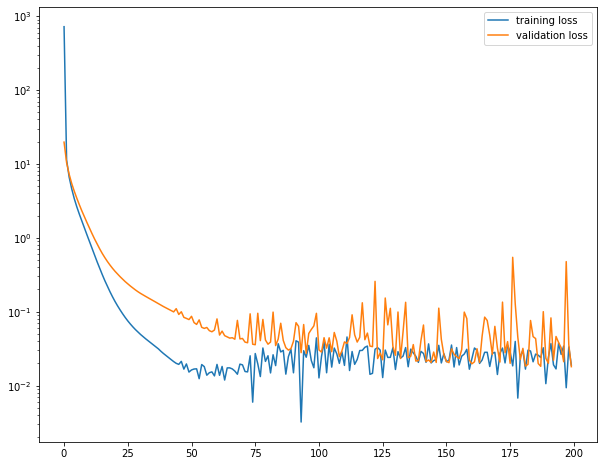

In [83]:
net = MLP(x.shape[-1], n_params=a.shape[1])

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

running_loss = 0
training_loss_list = []
validation_loss_list = []
best_coeff = 0
best_loss = torch.inf

figure, ax = plt.subplots(figsize=(10, 8))

for i in range(20000):
    optimizer.zero_grad()   # zero the gradient buffers
    a_pred = net(y_training)
    loss = criterion(a_training.squeeze(-1), a_pred)
    loss.backward()
    optimizer.step()  
    
    # print statistics
    running_loss += loss.item()
    if i % 100 == 99:
#        print(list(net.parameters()))
        a_pred = net(y_validation)
        validation_loss = criterion(a_validation.squeeze(-1), a_pred)
        validation_loss_list.append(validation_loss.cpu().detach().numpy())

        print(f'[{i + 1:5d}] training loss: {running_loss / 100:.8f}, validation loss: {validation_loss:.8f}', end='\r')
        training_loss_list.append(running_loss / 100)
        running_loss = 0.0
        

        
plt.plot(training_loss_list, label='training loss')
plt.plot(validation_loss_list, label='validation loss')
plt.legend()
plt.yscale('log')

In [84]:
criterion(net(y_test), a_test.squeeze(-1))

tensor(0.0090, grad_fn=<MseLossBackward0>)

In [85]:
a_test[:2], net(y_test[0:2])

(tensor([[[ 1.0499],
          [-0.4260],
          [ 1.0211],
          [-0.5475]],
 
         [[ 0.7720],
          [-0.0480],
          [-1.0342],
          [-1.2458]]]),
 tensor([[ 1.0654, -0.4185,  1.0252, -0.5406],
         [ 0.7938, -0.0560, -1.0220, -1.2446]], grad_fn=<AddmmBackward0>))

## 4. Now, let us come to a more complicated formula: $y=\cos(ax)b+c+\cos(dx)^2e$

In [194]:
class MLP(nn.Module):
    def __init__(self, L, n_params):
        super().__init__()
        self.fc1 = nn.Linear(L, 50)
        self.fc2 = nn.Linear(50, n_params)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [195]:
cos_mask = [True, False, False, True, False]
a = torch.randn(2000, 5, 1)
a[:, cos_mask] = torch.abs(a[:, cos_mask])
x = torch.arange(-10, 10, 0.1).unsqueeze(0)
y = torch.cos(a[:, 0]*x)* a[:, 1] + a[:, 2] + torch.cos(a[:, 3]*x)**2*a[:,4]
y_training = y[:1750]
a_training = a[:1750]
y_validation = y[1750:1850]
a_validation = a[1750:1850]
y_test = y[1850:]
a_test = a[1850:]

In [196]:
a[0:2]

tensor([[[ 0.3259],
         [-0.2992],
         [-0.1369],
         [ 1.2036],
         [-0.4098]],

        [[ 1.1779],
         [ 1.1548],
         [ 0.1162],
         [ 0.8440],
         [ 0.8691]]])

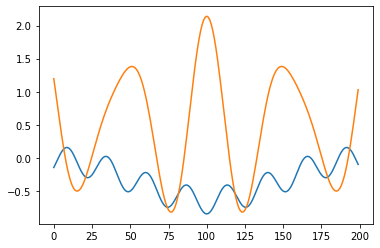

In [197]:
plt.plot(y[0:2].T)

In [198]:
net = MLP(x.shape[-1], n_params=a.shape[1])

In [199]:
a_pred = net(y_test)
a_pred[:,cos_mask] = torch.abs(a_pred[:,cos_mask])
criterion(a_pred, a_test.squeeze(-1))

tensor(1.1511, grad_fn=<MseLossBackward0>)

In [200]:
evaluate_functions(x, a_test, y_test, net)

tensor(2.9628, grad_fn=<MseLossBackward0>)

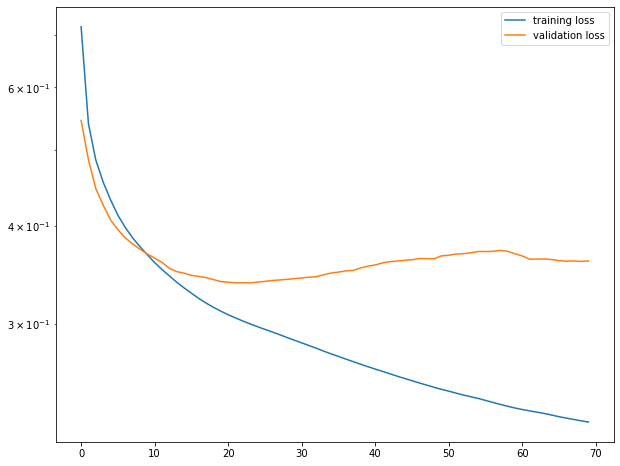

In [201]:

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

running_loss = 0
training_loss_list = []
validation_loss_list = []
best_coeff = 0
best_loss = torch.inf

figure, ax = plt.subplots(figsize=(10, 8))

for i in range(7000):
    optimizer.zero_grad()   # zero the gradient buffers
    a_pred = net(y_training)
    a_pred[:,cos_mask] = torch.abs(a_pred[:,cos_mask])
    loss = criterion(a_training.squeeze(-1), a_pred)
    loss.backward()
    optimizer.step()  
    
    # print statistics
    running_loss += loss.item()
    if i % 100 == 99:
#        print(list(net.parameters()))
        a_pred = net(y_validation)
        a_pred[:,cos_mask] = torch.abs(a_pred[:,cos_mask])
        validation_loss = criterion(a_validation.squeeze(-1), a_pred)
        validation_loss_list.append(validation_loss.cpu().detach().numpy())
        
        print(f'[{i + 1:5d}] training loss: {running_loss / 100:.8f}, validation loss: {validation_loss:.8f}', end='\r')
        training_loss_list.append(running_loss / 100)
        running_loss = 0.0
        

        
plt.plot(training_loss_list, label='training loss')
plt.plot(validation_loss_list, label='validation loss')
plt.legend()
plt.yscale('log')

In [202]:
a_pred = net(y_test)
a_pred[:,cos_mask] = torch.abs(a_pred[:,cos_mask])
criterion(a_pred, a_test.squeeze(-1))

tensor(0.3824, grad_fn=<MseLossBackward0>)

In [203]:
evaluate_functions(x, a_test, y_test, net)

tensor(0.6770, grad_fn=<MseLossBackward0>)

In [204]:
a_test[:2], net(y_test[:2])

(tensor([[[ 0.4459],
          [ 0.2341],
          [ 0.4378],
          [ 0.4235],
          [ 2.0879]],
 
         [[ 1.6443],
          [-1.1640],
          [-1.8842],
          [ 0.4464],
          [ 0.3019]]]),
 tensor([[-0.9275,  1.0994,  0.8411,  0.9233,  0.7663],
         [-1.3355, -0.9644, -1.1886, -0.6237, -0.7170]],
        grad_fn=<AddmmBackward0>))

In [205]:
a[:2], net(y[0:2])

(tensor([[[ 0.3259],
          [-0.2992],
          [-0.1369],
          [ 1.2036],
          [-0.4098]],
 
         [[ 1.1779],
          [ 1.1548],
          [ 0.1162],
          [ 0.8440],
          [ 0.8691]]]),
 tensor([[-0.5376, -0.2722, -0.0468, -0.6197, -0.5840],
         [-1.3283,  1.2342,  0.3630,  0.3204,  0.6447]],
        grad_fn=<AddmmBackward0>))

In [206]:
def evaluate_functions(x, a, y, net):
    a_pred = net(y)
    a_pred[:,cos_mask] = torch.abs(a_pred[:,cos_mask])
    a_pred = a_pred.unsqueeze(-1)
    y_pred = torch.cos(a_pred[:, 0]*x)* a_pred[:, 1] + a_pred[:, 2] + torch.cos(a_pred[:, 3]*x)**2*a_pred[:,4]
    return criterion(y_pred, y_test)

In [207]:
evaluate_functions(x, a_test, y_test, net)

tensor(0.6770, grad_fn=<MseLossBackward0>)

In [208]:
a_pred = net(y_test[:2])
a_pred[:,cos_mask] = torch.abs(a_pred[:,cos_mask])
a_pred = a_pred.unsqueeze(-1)
y_pred = torch.cos(a_pred[:, 0]*x)* a_pred[:, 1] + a_pred[:, 2] + torch.cos(a_pred[:, 3]*x)**2*a_pred[:,4]

In [211]:
criterion(y_pred[:2], y[:2])

tensor(4.9348, grad_fn=<MseLossBackward0>)

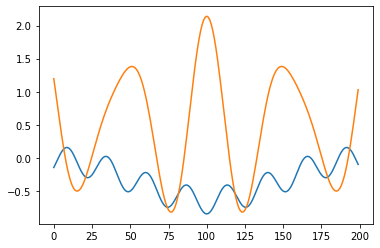

In [212]:
plt.plot(y[:2].T)

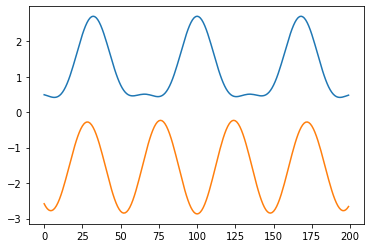

In [213]:
plt.plot(y_pred.detach().numpy().T)

In [100]:
a_pred.shape, x.shape

(torch.Size([2, 5]), torch.Size([1, 200]))

In [96]:
a_pred[:, 0]*x

RuntimeError: The size of tensor a (2) must match the size of tensor b (200) at non-singleton dimension 1